The goal of this notebook is to explore the "delta kick model", which is a way of working with the IDE where we decompose a laser pulse into a series of delta-function kicks. This lets us look at how time delays between parts of the pulse directly couple to the kernel, causing intereference and therefore changing the resulting ionization probability.

At the moment, this model has some pretty severe limits. Because we're changing the electric field, we can't really do anything involving the vector potential. This limits us to using the most-approximate versions of the IDE kernel, ones that have no dependence on the vector potential.

Most of the delta kick code was actually moved into the library a long time ago, so we'll just access it from there.

In [1]:
import logging
import os
import functools
import datetime

import numpy as np

import simulacra as si
import simulacra.units as u

import ionization as ion
import ionization.ide.delta_kicks as dk

LOGMAN = si.utils.LogManager('simulacra', 'ionization', stdout_level = logging.INFO)
THIS_DIR = os.getcwd()
OUT_DIR = os.path.join(THIS_DIR, 'out', 'DeltaKickModel')
SIM_LIB = os.path.join(OUT_DIR, 'SIMLIB')

PLOT_KWARGS = dict(
    show = True,
    save = True,
    target_dir = OUT_DIR,
    fig_dpi_scale = 1.5,
)

%matplotlib inline

The first thing we'll look at is a basic "sine-like" delta-kick. It's made of two kicks of opposite polarity. We'll center them around $t=0$ for convenience.

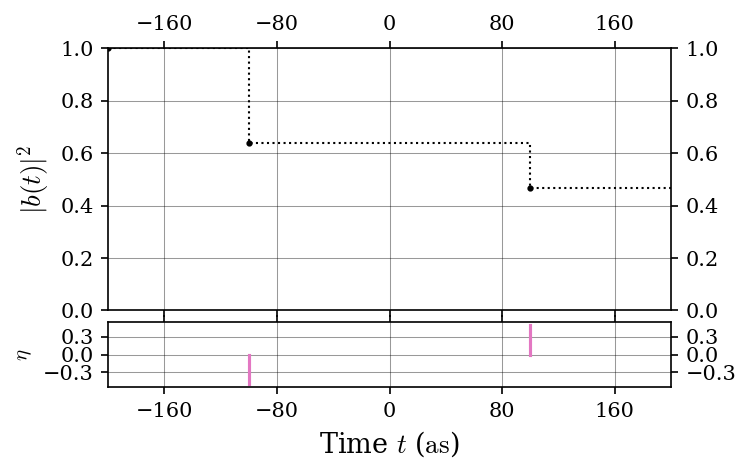

In [2]:
amp = .5 * u.atomic_electric_field * u.atomic_time
delay = 200 * u.asec
sine_kicks = dk.DeltaKicks([
    dk.delta_kick(-delay / 2, -amp),
    dk.delta_kick(delay / 2, amp),
])

sine_kick_sim = dk.DeltaKickSpecification(
    'sine_kick',
    time_initial = -200 * u.asec,
    time_final = 200 *  u.asec,
    electric_potential = sine_kicks,
    kernel = ion.ide.LengthGaugeHydrogenKernel(),
).to_sim()

sine_kick_sim.run()

sine_kick_sim.plot_b2_vs_time(**PLOT_KWARGS)

Pulling out the full machinery is pointless for such a small number of kicks. Instead, we can solve for the probability amplitude directly and find that
$$ b(t_f) = \frac{1 + \frac{q^2}{\hbar^2} \, \eta_0^2 \, K_b(\Delta)}{\left[1 + \frac{q^2}{\hbar^2} \, \eta_0^2 \, K_b(0)\right]^2} $$

In [3]:
length_gauge_hydrogen_kernel = ion.ide.LengthGaugeHydrogenKernel()  # outside, for caching
def b_after_sine_like_kicks(delay, amplitude):
    pre = (u.electron_charge * amplitude / u.hbar) ** 2
    num = 1 + (pre * length_gauge_hydrogen_kernel._evaluate_kernel_function(delay))
    den = (1 + (pre * length_gauge_hydrogen_kernel._evaluate_kernel_function(0))) ** 2
    
    return num / den

In [4]:
print(sine_kick_sim.b2[-1])
print(np.abs(b_after_sine_like_kicks(delay, amp)) ** 2)

0.4671867680018935
0.4671867680018937


The two methods obviously agree. We can visualize this relationship over parameter ranges in a few different ways. What you get generally just reflects the shape of the kernel: a decaying sinusoid, centered around the limiting value
$$ b(t_f) = \frac{1}{\left[1 + \frac{q^2}{\hbar^2} \, \eta_0^2 \, K_b(0)\right]^2} $$
where $\Delta \to \infty$ and $K_b(\Delta) \to 0$.

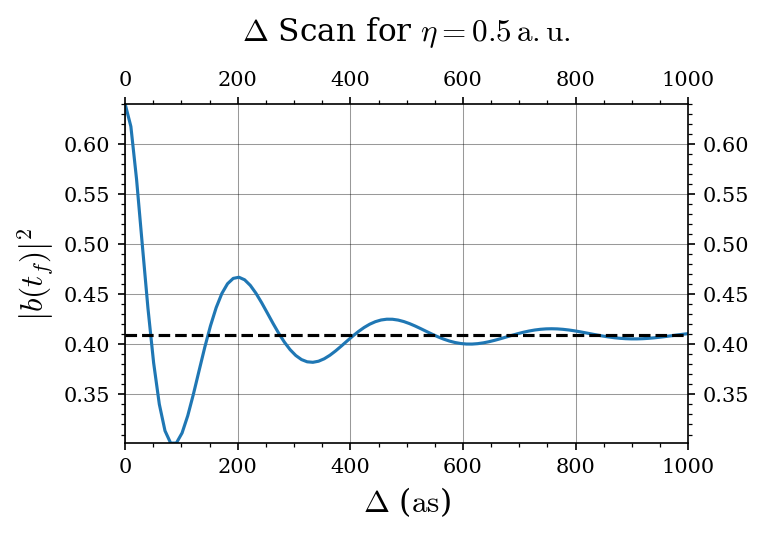

In [5]:
def sine_like_kick_delay_scan():
    delays = np.linspace(0, 1000, 100) * u.asec
    amplitude = 0.5 * u.atomic_electric_field * u.atomic_time
    
    b2 = np.abs(b_after_sine_like_kicks(delays, amplitude)) ** 2
    
    si.vis.xy_plot(
        'sine_like_kick_delay_scan',
        delays,
        b2,
        hlines = [np.abs(b_after_sine_like_kicks(np.inf, amplitude)) ** 2],
        hline_kwargs = [{'linestyle': '--'}],
        x_unit = 'asec',
        x_label = r'$ \Delta $',
        y_label = r'$ \left| b(t_f) \right|^2 $',
        title = r'$ \Delta $ Scan for $ \eta = 0.5 \, \mathrm{a.u.} $',
        **PLOT_KWARGS
    )
    
sine_like_kick_delay_scan()

We can also look at it over $\Delta$ and $\eta$ space simultaneously using a heatmap.

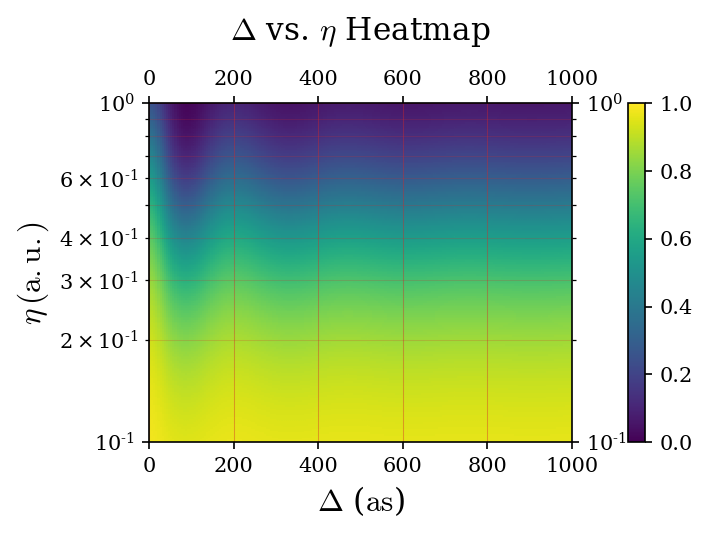

In [6]:
def sine_like_kick_heatmap():
    delays = np.linspace(0, 1000, 200) * u.asec
    amplitudes = np.geomspace(0.1, 1, 200) * u.atomic_electric_field * u.atomic_time
    
    delay_mesh, amplitude_mesh = np.meshgrid(delays, amplitudes, indexing = 'ij')
    
    b2 = np.abs(b_after_sine_like_kicks(delay_mesh, amplitude_mesh)) ** 2
    
    si.vis.xyz_plot(
        'sine_like_kick_heatmap',
        delay_mesh,
        amplitude_mesh,
        b2,
        y_log_axis = True,
        z_lower_limit = 0,
        z_upper_limit = 1,
        x_unit = 'asec',
        y_unit = u.atomic_electric_field * u.atomic_time,
        x_label = r'$ \Delta $',
        y_label = r'$ \eta \, (\mathrm{a.u.}) $',
        title = r'$\Delta$ vs. $\eta$ Heatmap',
        **PLOT_KWARGS,
    )
    
sine_like_kick_heatmap()

We see that we only get a significant absolute contrast when in a limited range of $\eta$, and the the shape is always the familiar kernel-like sinusoid. This matches our intuition about the IDE doing interesting things in the BSI regime, where the field is extreme but not too extreme.

We can also seamlessly feed in an actual pulse. Well, almost seamlessly. We have to specify a pretty small time step to make sure that the decomposition algorithm catches every "chunck" of the field. For this pulse and time window, with $\Delta t = 1 \, \mathrm{as}$, the algorithm lumps the last lobe of the field in with the second central lobe. Reducing the time step to $\Delta t = 0.1 \, \mathrm{as}$ lets it get the right decomposition.

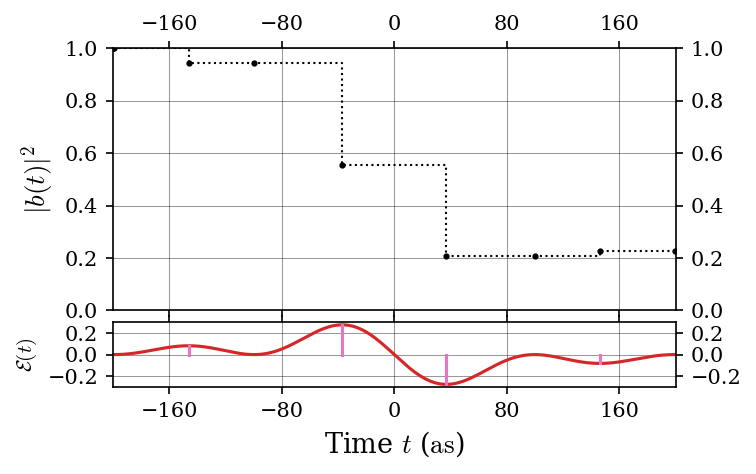

In [7]:
pulse = ion.potentials.SincPulse(pulse_width = 100 * u.asec, fluence = .5 * u.Jcm2, phase = u.pi / 2)

pulse_sim = dk.DeltaKickSpecification(
    'pulse',
    time_initial = -200 * u.asec,
    time_final = 200 *  u.asec,
    time_step = .1 * u.asec,
    electric_potential = pulse,
    kernel = ion.ide.LengthGaugeHydrogenKernel(),
).to_sim()

pulse_sim.run()

pulse_sim.plot_b2_vs_time(**PLOT_KWARGS)